In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('..')

import torch
from PIL import Image
from diffusers import DiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPModel

from utils import show_images

### Load CLIP model

In [2]:
feature_extractor = CLIPFeatureExtractor.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
)
clip_model = CLIPModel.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K", torch_dtype=torch.float16
)

/home/user/Projects/denk_baseline/venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### Create DiffusionPipeline from local .py file

In [3]:
mixing_pipeline = DiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    custom_pipeline="../images_mixing.py",
    clip_model=clip_model,
    feature_extractor=feature_extractor,
    torch_dtype=torch.float16,
)
mixing_pipeline = mixing_pipeline.to("cuda")

  0%|          | 0/35 [00:00<?, ?it/s]

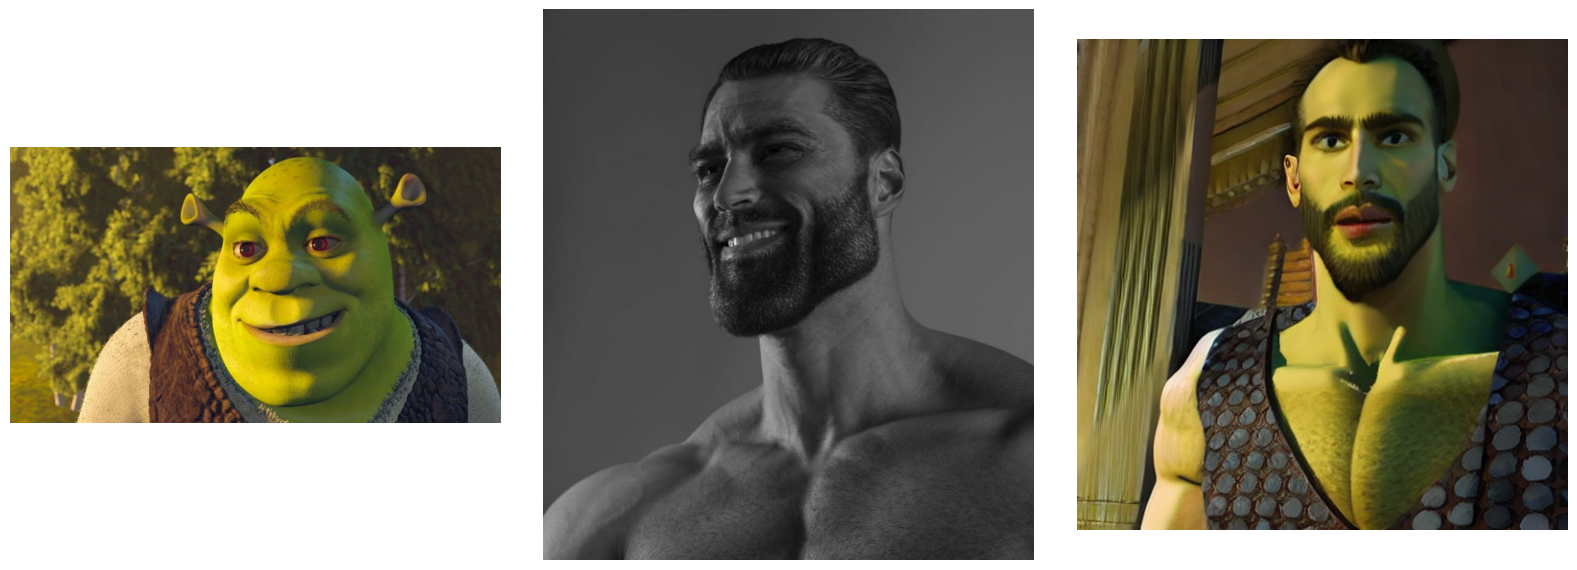

In [4]:
generator = torch.Generator(device="cuda").manual_seed(17) 

content_image = Image.open('../images/shrek.jpg').convert("RGB")
style_image = Image.open('../images/gigachad.jpg').convert("RGB")

pipe_images = mixing_pipeline(
    num_inference_steps=50,
    content_prompt='shrek',   # can be skipped if CoCa model exists
    style_prompt='gigachad',  # can be skipped if CoCa model exists
    content_image=content_image,
    style_image=style_image,
    noise_strength=0.7,
    slerp_latent_style_strength=0.2,
    slerp_prompt_style_strength=0.8,
    slerp_clip_image_style_strength=0.8,
    guidance_scale=9.0,
    batch_size=1,
    clip_guidance_scale=100,
    generator=generator,
).images

show_images([content_image, style_image, pipe_images[0]], figsize=(16, 8))